In [1]:
import tensorflow as tf
import numpy as np
import time
import matplotlib.pyplot as plt
from tensorflow import keras
plt.style.use('default')
print("TensorFlow version:", tf.__version__)
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, BatchNormalization, Activation
from tensorflow.keras.layers import Reshape,Conv2D, MaxPooling2D,Conv1D, MaxPooling1D
from tensorflow.keras.initializers import RandomNormal, GlorotNormal, he_normal,HeNormal
import tarfile
import os
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import pickle
from tensorflow.keras.models import load_model
import tensorflow_addons as tfa

2023-11-06 15:20:55.414512: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


TensorFlow version: 2.13.1


/Users/sahildhingra/opt/anaconda3/lib/python3.8/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
import soundfile as sf
from keras.callbacks import EarlyStopping
#!pip install librosa # in colab, you’ll need to install this
import librosa

# **Speech Denoising**

Summary: 
- Load Traininf data (dirty and clean) - (Librosa)
- Do STFT - To convert to spectograms - Matrix form. 
- Take magnitude (np.abs).
- DNN Network with couple of layers. - Input will be transposed, i.e. 513-dim column vector.
- Non negative output - Use Relu in the last layer.
- Use test_x_01 for validation. 
- Recover speech spectogram - X/|Xtest| * Stest (predicted clean magnitude spectrum)
- Do inverse STFT to save the denoised audio)
- Canculate SNR: I/P - Clean and Denoised audio.
    - 10* log10 (sum(y**2) /sum(square(y-yhat)))
- Use the model to get denoised audio of test file 2.

**Importing the dataset clean and dirty**

In [3]:
import librosa
s, srs = librosa.load('/Users/sahildhingra/Downloads/MSDS/SEM_6/Deep Learning/data/train_clean_male.wav',sr=None)
S = librosa.stft(s, n_fft=1024, hop_length=512)
sn, srx = librosa.load('/Users/sahildhingra/Downloads/MSDS/SEM_6/Deep Learning/data/train_dirty_male.wav',sr=None)
X = librosa.stft(sn, n_fft =1024,hop_length=512)
S_ab = np.abs(S)
X_ab = np.abs(X)
Sab_T = S_ab.T
Xab_T = X_ab.T
Xab_T.shape,Sab_T.shape

((2459, 513), (2459, 513))

In [9]:
X_ab.shape,S_ab.shape, s.shape, S.shape,Xab_T.shape,Sab_T.shape

((513, 2459), (513, 2459), (1258899,), (513, 2459), (2459, 513), (2459, 513))

In [14]:
sx, srt3 = librosa.load('/Users/sahildhingra/Downloads/MSDS/SEM_6/Deep Learning/data/test_x_01.wav',sr=None)
Xtest = librosa.stft(sx, n_fft=1024, hop_length=512)
Xtest_ab = np.abs(Xtest)
Xtest_ab.shape

(513, 142)

In [15]:
clean_audio, sr_clean = librosa.load('/Users/sahildhingra/Downloads/MSDS/SEM_6/Deep Learning/data/test_s_01.wav', sr=None)
ca = librosa.stft(clean_audio, n_fft=1024, hop_length=512)
ca_ab = np.abs(ca)

In [16]:
def SNR(clean_audio,Stest_inv):
    
    min_length = min(len(clean_audio), len(Stest_inv))
    clean_audio = clean_audio[:min_length]
    Stest_inv = Stest_inv[:min_length]
    return 10 * np.log10((np.sum(np.square(clean_audio)))/(np.sum(np.square(clean_audio-Stest_inv +1e-20))))

**Creating and Running the baseline DNN model**

In [11]:
initializer = tf.keras.initializers.HeNormal(seed=42)

# DNN model
m1 = Sequential()
m1.add(Flatten(input_shape=(513, 1)))
m1.add(Dense(256, kernel_initializer=initializer, activation=tf.keras.layers.LeakyReLU(alpha=0.4)))
m1.add(Dense(128, kernel_initializer=initializer, activation=tf.keras.layers.LeakyReLU(alpha=0.34)))
m1.add(Dense(513, activation='relu', kernel_initializer=initializer, bias_initializer=tf.keras.initializers.Zeros()))

m1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 513)               0         
                                                                 
 dense (Dense)               (None, 256)               131584    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 513)               66177     
                                                                 
Total params: 230657 (901.00 KB)
Trainable params: 230657 (901.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [12]:
optimize_adam = tf.keras.optimizers.Adam(learning_rate=0.001)
m1.compile(optimizer=optimize_adam,loss= tf.keras.losses.MeanSquaredError())

**Execute Model for 500 epochs. Early stopping if overfitting**

In [17]:
#Ref: https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/
es = [EarlyStopping(monitor='val_loss',patience=100,verbose=1,mode='auto')]
m1.fit(Xab_T,Sab_T,epochs=2, batch_size = 64,validation_data=(Xtest_ab.T,ca_ab.T),callbacks=es)

Epoch 1/2
39/39 [==============================] - 2s 17ms/step - loss: 0.0956 - val_loss: 0.2199
Epoch 2/2
39/39 [==============================] - 0s 7ms/step - loss: 0.0454 - val_loss: 0.1817


In [18]:
Xtest_ab.T.shape

(142, 513)

In [22]:
Shtest_ab = m1.predict(Xtest_ab.T)
Shtest_ab.shape

5/5 [==============================] - 0s 2ms/step


(142, 513)

In [23]:
Shtest_ab = Shtest_ab.T
Shtest_ab.shape

(513, 142)

In [24]:


Stest = np.multiply(np.divide(Xtest,Xtest_ab), Shtest_ab) 
Stest.shape

(513, 142)

**Test set 1**

In [24]:
#test_x_01


Stest_inv = librosa.istft(Stest,hop_length=512)
Stest_inv.shape

5/5 [==============================] - 0s 2ms/step


(72192,)

In [25]:
sf.write('/Users/sahildhingra/Downloads/MSDS/SEM_6/Deep Learning/data/test_s_01_recons.wav', Stest_inv, srt3)

In [26]:
#https://saturncloud.io/blog/how-to-play-audio-in-jupyter-using-python/
from IPython.display import Audio
audio = Audio(Stest_inv, rate = srt3)
# Display the audio player
display(audio)

## SNR for audio

In [27]:
SNR(clean_audio,Stest_inv)

10.697323083877563

In [28]:
#X2
s, srt2 = librosa.load('/Users/sahildhingra/Downloads/MSDS/SEM_6/Deep Learning/data/test_x_02.wav',sr=None)
Xtest = librosa.stft(s, n_fft=1024, hop_length=512)
Xtest_ab = np.abs(Xtest)
Xtest_ab.shape

(513, 380)

In [29]:
#test_x_02
Shtest_ab = m1.predict(Xtest_ab.T)
Shtest_ab.shape
Shtest_ab = Shtest_ab.T
Shtest_ab.shape
Stest = np.multiply(np.divide(Xtest,Xtest_ab), Shtest_ab) 
Stest.shape
Stest_inv = librosa.istft(Stest,hop_length=512)
Stest_inv.shape

12/12 [==============================] - 0s 2ms/step


(194048,)

## Denoised Test 02 audio (DNN)

In [30]:
sf.write('/Users/sahildhingra/Downloads/MSDS/SEM_6/Deep Learning/data/test_s_02_recons.wav', Stest_inv, srt2)

In [31]:
#https://saturncloud.io/blog/how-to-play-audio-in-jupyter-using-python/
from IPython.display import Audio
audio = Audio(Stest_inv, rate = srt2)

# Display the audio player
display(audio)

# CNN 1D

**Summary:**
- Use the same data as above and process through the CNN1D model. 
- Strides, Kernel size  = 1*S, 1*K



In [32]:
sx, srt3 = librosa.load('/Users/sahildhingra/Downloads/MSDS/SEM_6/Deep Learning/data/test_x_01.wav',sr=None)
Xtest = librosa.stft(sx, n_fft=1024, hop_length=512)
Xtest_ab = np.abs(Xtest)
Xtest_ab.shape

(513, 142)

**Creating and Running the CNN 1D model**

## CNN  1D Model

In [33]:
initializer = tf.keras.initializers.HeNormal(seed = 42)
m2 = Sequential()
m2.add(Conv1D(filters=32,kernel_size=4,strides = 2,input_shape=(513,1),kernel_initializer=initializer,
                  activation = tf.keras.layers.LeakyReLU(alpha= 0.4)))
m2.add(MaxPooling1D(pool_size=2,strides=2))
m2.add(Conv1D(filters=64,kernel_size=2,strides = 2,activation = tf.keras.layers.LeakyReLU(alpha= 0.34),
                   kernel_initializer=initializer))
m2.add(Flatten())
m2.add(Dense(513,activation= tf.nn.relu,kernel_initializer=initializer, bias_initializer= tf.keras.initializers.Zeros()))


In [34]:
m2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 255, 32)           160       
                                                                 
 max_pooling1d (MaxPooling1  (None, 127, 32)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 63, 64)            4160      
                                                                 
 flatten_4 (Flatten)         (None, 4032)              0         
                                                                 
 dense_10 (Dense)            (None, 513)               2068929   
                                                                 
Total params: 2073249 (7.91 MB)
Trainable params: 2073249 (7.91 MB)
Non-trainable params: 0 (0.00 Byte)
________________

In [35]:
optimize_adam = tf.keras.optimizers.Adam(learning_rate=0.001)
m2.compile(optimizer=optimize_adam,loss=tf.keras.losses.MeanSquaredError())

In [36]:
es = [EarlyStopping(monitor='val_loss',patience=200,verbose=2,mode='auto')]
q2 = m2.fit(Xab_T,Sab_T,epochs=500, batch_size = 64,validation_data=(Xtest_ab.T,ca_ab.T),callbacks=es)

Epoch 1/500
39/39 [==============================] - 2s 39ms/step - loss: 0.0678 - val_loss: 0.2148
Epoch 2/500
39/39 [==============================] - 1s 34ms/step - loss: 0.0448 - val_loss: 0.1922
Epoch 3/500
39/39 [==============================] - 2s 40ms/step - loss: 0.0404 - val_loss: 0.1865
Epoch 4/500
39/39 [==============================] - 2s 39ms/step - loss: 0.0385 - val_loss: 0.1816
Epoch 5/500
39/39 [==============================] - 2s 39ms/step - loss: 0.0377 - val_loss: 0.1780
Epoch 6/500
39/39 [==============================] - 1s 37ms/step - loss: 0.0369 - val_loss: 0.1741
Epoch 7/500
39/39 [==============================] - 1s 36ms/step - loss: 0.0361 - val_loss: 0.1735
Epoch 8/500
39/39 [==============================] - 1s 33ms/step - loss: 0.0344 - val_loss: 0.1695
Epoch 9/500
39/39 [==============================] - 1s 35ms/step - loss: 0.0321 - val_loss: 0.1630
Epoch 10/500
39/39 [==============================] - 1s 32ms/step - loss: 0.0312 - val_loss: 0.1630

39/39 [==============================] - 1s 36ms/step - loss: 0.0020 - val_loss: 0.0284
Epoch 163/500
39/39 [==============================] - 1s 35ms/step - loss: 0.0019 - val_loss: 0.0282
Epoch 164/500
39/39 [==============================] - 1s 34ms/step - loss: 0.0019 - val_loss: 0.0287
Epoch 165/500
39/39 [==============================] - 1s 30ms/step - loss: 0.0018 - val_loss: 0.0279
Epoch 166/500
39/39 [==============================] - 1s 31ms/step - loss: 0.0019 - val_loss: 0.0290
Epoch 167/500
39/39 [==============================] - 1s 30ms/step - loss: 0.0019 - val_loss: 0.0279
Epoch 168/500
39/39 [==============================] - 1s 27ms/step - loss: 0.0019 - val_loss: 0.0277
Epoch 169/500
39/39 [==============================] - 1s 29ms/step - loss: 0.0018 - val_loss: 0.0278
Epoch 170/500
39/39 [==============================] - 1s 28ms/step - loss: 0.0018 - val_loss: 0.0282
Epoch 171/500
39/39 [==============================] - 1s 28ms/step - loss: 0.0018 - val_loss: 0

39/39 [==============================] - 1s 34ms/step - loss: 0.0010 - val_loss: 0.0235
Epoch 323/500
39/39 [==============================] - 1s 35ms/step - loss: 0.0010 - val_loss: 0.0234
Epoch 324/500
39/39 [==============================] - 1s 36ms/step - loss: 9.8831e-04 - val_loss: 0.0235
Epoch 325/500
39/39 [==============================] - 1s 36ms/step - loss: 0.0010 - val_loss: 0.0238
Epoch 326/500
39/39 [==============================] - 1s 35ms/step - loss: 0.0010 - val_loss: 0.0235
Epoch 327/500
39/39 [==============================] - 1s 33ms/step - loss: 0.0010 - val_loss: 0.0240
Epoch 328/500
39/39 [==============================] - 1s 34ms/step - loss: 0.0010 - val_loss: 0.0235
Epoch 329/500
39/39 [==============================] - 1s 35ms/step - loss: 0.0011 - val_loss: 0.0239
Epoch 330/500
39/39 [==============================] - 1s 35ms/step - loss: 0.0011 - val_loss: 0.0239
Epoch 331/500
39/39 [==============================] - 1s 36ms/step - loss: 0.0011 - val_los

39/39 [==============================] - 1s 35ms/step - loss: 7.6345e-04 - val_loss: 0.0229
Epoch 478/500
39/39 [==============================] - 1s 35ms/step - loss: 7.5022e-04 - val_loss: 0.0229
Epoch 479/500
39/39 [==============================] - 1s 37ms/step - loss: 7.3034e-04 - val_loss: 0.0228
Epoch 480/500
39/39 [==============================] - 1s 33ms/step - loss: 7.2394e-04 - val_loss: 0.0226
Epoch 481/500
39/39 [==============================] - 1s 36ms/step - loss: 7.3881e-04 - val_loss: 0.0228
Epoch 482/500
39/39 [==============================] - 1s 36ms/step - loss: 7.3676e-04 - val_loss: 0.0226
Epoch 483/500
39/39 [==============================] - 1s 35ms/step - loss: 7.7163e-04 - val_loss: 0.0229
Epoch 484/500
39/39 [==============================] - 1s 36ms/step - loss: 7.8544e-04 - val_loss: 0.0229
Epoch 485/500
39/39 [==============================] - 1s 36ms/step - loss: 7.8913e-04 - val_loss: 0.0231
Epoch 486/500
39/39 [==============================] - 1s 36

**Test set 1**

In [37]:
Shtest_ab = m2.predict(Xtest_ab.T)
Shtest_ab.shape
Shtest_ab = Shtest_ab.T
Shtest_ab.shape
Stest = np.multiply(np.divide(Xtest,Xtest_ab), Shtest_ab) 
Stest.shape
Stest_inv = librosa.istft(Stest,hop_length=512)
Stest_inv.shape

5/5 [==============================] - 0s 4ms/step


(72192,)

In [38]:
sf.write('/Users/sahildhingra/Downloads/MSDS/SEM_6/Deep Learning/data/test_s_01_cnn_recons.wav', Stest_inv, srt3)

In [39]:
from IPython.display import Audio
audio = Audio(Stest_inv, rate = srt3)

# Display the audio player
display(audio)

## SNR for Test Audio

In [40]:
SNR(clean_audio,Stest_inv)

11.370439529418945

In [41]:
# X02

In [47]:
s, srt2 = librosa.load('/Users/sahildhingra/Downloads/MSDS/SEM_6/Deep Learning/data/test_x_02.wav',sr=None)
Xtest = librosa.stft(s, n_fft=1024, hop_length=512)
Xtest_ab = np.abs(Xtest)
Xtest_ab.shape

(513, 380)

In [48]:
#x02
Shtest_ab = m2.predict(Xtest_ab.T)
Shtest_ab.shape
Shtest_ab = Shtest_ab.T
Shtest_ab.shape
Stest = np.multiply(np.divide(Xtest,Xtest_ab), Shtest_ab) 
Stest.shape
Stest_inv = librosa.istft(Stest,hop_length=512)
Stest_inv.shape

12/12 [==============================] - 0s 5ms/step


(194048,)

## Denoised test 02 audio (CNN)

In [49]:
sf.write('/Users/sahildhingra/Downloads/MSDS/SEM_6/Deep Learning/data/test_s_02_cnn_recons.wav', Stest_inv, srt2)

In [50]:
from IPython.display import Audio
audio = Audio(Stest_inv, rate = srt2)

# Display the audio player
display(audio)

# CIFAR 10 Data

**Load the data**
- Download CIFAR10 Data.
- Divide into Train, Validation and Test set.
        - Train      - 45000
        - Validation - 5000
        - Test       - 10000

In [4]:
# Path to the tar file
tar_file_path = '/Users/sahildhingra/Downloads/MSDS/SEM_6/Deep Learning/HW/HW2/cifar-10-python.tar'

# Extract the tar file
with tarfile.open(tar_file_path, 'r') as tar:
    tar.extractall()

# Load CIFAR-10 data from extracted files
def load_cifar10_batch(file_path):
    with open(file_path, 'rb') as fo:
        data = pickle.load(fo, encoding='bytes')
    return data

# Load all training batches and concatenate them
all_train_images = []
all_train_labels = []
for i in range(1, 6):  
    batch_data = load_cifar10_batch(f'cifar-10-batches-py/data_batch_{i}')
    batch_images = np.array(batch_data[b'data']).reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
    batch_labels = np.array(batch_data[b'labels'])
    all_train_images.append(batch_images)
    all_train_labels.append(batch_labels)

# Concatenate all training batches
train_images = np.concatenate(all_train_images, axis=0)
train_labels = np.concatenate(all_train_labels, axis=0)

#  test data
test_data = load_cifar10_batch('cifar-10-batches-py/test_batch')
test_images = np.array(test_data[b'data']).reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
test_labels = np.array(test_data[b'labels'])

# Split data into train, validation, and test sets
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels,shuffle = True, test_size=0.1, random_state=42,stratify = train_labels)

print("Train Images Shape:", train_images.shape)
print("Train Labels Shape:", train_labels.shape)
print("Validation Images Shape:", val_images.shape)
print("Validation Labels Shape:", val_labels.shape)
print("Test Images Shape:", test_images.shape)
print("Test Labels Shape:", test_labels.shape)


Train Images Shape: (45000, 32, 32, 3)
Train Labels Shape: (45000,)
Validation Images Shape: (5000, 32, 32, 3)
Validation Labels Shape: (5000,)
Test Images Shape: (10000, 32, 32, 3)
Test Labels Shape: (10000,)


**Normalize and Rescale function:**
- Normalize: Each pixel will be transformed to [0,1]
- Rescale : Input is normalized data, rescale image to scale [-1,1]

In [5]:
def normalize(X):
    X = X/255.  #[0,1]
    return X

def rescale(X):
    rescaled = X * 2 - 1
    return rescaled

In [6]:
train_scaled = rescale(normalize(train_images))
val_scaled = rescale(normalize(val_images))
val_norm = normalize(val_images)
train_norm = normalize(train_images)
#test_scaled = rescale(normalize(test_images))


## Baseline CNN Model:
- 1st 2d conv layer: there are 10 kernels whose size is 5x5x3; stride=1
- Maxpooling: 2x2 with stride=2
- 1st 2d conv layer: there are 10 kernels whose size is 5x5x10; stride=1
- Maxpooling: 2x2 with stride=2
- 1st fully-connected layer: [flattened final feature map] x 20
- 2st fully-connected layer: 20 x 10 Softmax on the 10 classes

In [7]:

def create_cnn_model(input_shape=(32, 32, 3), num_classes=10):
    # Input layer
    input_layer = Input(shape=input_shape)
    
    conv1 = Conv2D(10, (5, 5), strides=(1, 1), kernel_initializer=he_normal(), activation='relu')(input_layer)
    
    maxpool1 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(conv1)
    
    conv2 = Conv2D(10, (5, 5), strides=(1, 1), activation='relu',kernel_initializer=he_normal())(maxpool1)
    
    maxpool2 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(conv2)
    
    flatten = Flatten()(maxpool2)
    
    fc1 = Dense(20, activation='relu',kernel_initializer=he_normal())(flatten)
    
    output_layer = Dense(num_classes, activation='softmax')(fc1)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    
    return model


model1 = (create_cnn_model)
model1 = model1()
model1.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 10)        760       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 10)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 10)        2510      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 10)          0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 250)               0     

In [8]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss = tf.keras.losses.categorical_crossentropy
model1.compile(optimizer= optimizer, metrics=["accuracy"], loss = tf.keras.losses.sparse_categorical_crossentropy)

In [9]:
epochs = 200
q3_1 = model1.fit(train_scaled, train_labels, epochs=epochs, validation_data=(val_scaled,val_labels), batch_size = 128)

Epoch 1/200
352/352 [==============================] - 13s 36ms/step - loss: 1.8185 - accuracy: 0.3287 - val_loss: 1.5448 - val_accuracy: 0.4398
Epoch 2/200
352/352 [==============================] - 12s 35ms/step - loss: 1.4700 - accuracy: 0.4693 - val_loss: 1.4248 - val_accuracy: 0.4814
Epoch 3/200
352/352 [==============================] - 12s 35ms/step - loss: 1.3679 - accuracy: 0.5096 - val_loss: 1.3268 - val_accuracy: 0.5260
Epoch 4/200
352/352 [==============================] - 13s 37ms/step - loss: 1.3118 - accuracy: 0.5308 - val_loss: 1.3050 - val_accuracy: 0.5332
Epoch 5/200
352/352 [==============================] - 13s 38ms/step - loss: 1.2700 - accuracy: 0.5480 - val_loss: 1.2706 - val_accuracy: 0.5434
Epoch 6/200
352/352 [==============================] - 14s 39ms/step - loss: 1.2375 - accuracy: 0.5600 - val_loss: 1.2376 - val_accuracy: 0.5608
Epoch 7/200
352/352 [==============================] - 13s 37ms/step - loss: 1.2074 - accuracy: 0.5708 - val_loss: 1.2153 - val_ac

352/352 [==============================] - 12s 35ms/step - loss: 0.8251 - accuracy: 0.7104 - val_loss: 1.0494 - val_accuracy: 0.6480
Epoch 114/200
352/352 [==============================] - 12s 35ms/step - loss: 0.8264 - accuracy: 0.7100 - val_loss: 1.0182 - val_accuracy: 0.6552
Epoch 115/200
352/352 [==============================] - 12s 35ms/step - loss: 0.8259 - accuracy: 0.7082 - val_loss: 1.0178 - val_accuracy: 0.6588
Epoch 116/200
352/352 [==============================] - 13s 38ms/step - loss: 0.8257 - accuracy: 0.7092 - val_loss: 1.0453 - val_accuracy: 0.6536
Epoch 117/200
352/352 [==============================] - 14s 39ms/step - loss: 0.8248 - accuracy: 0.7086 - val_loss: 1.0497 - val_accuracy: 0.6520
Epoch 118/200
352/352 [==============================] - 13s 36ms/step - loss: 0.8292 - accuracy: 0.7077 - val_loss: 1.0360 - val_accuracy: 0.6522
Epoch 119/200
352/352 [==============================] - 12s 34ms/step - loss: 0.8194 - accuracy: 0.7123 - val_loss: 1.0402 - val_ac

Epoch 169/200
352/352 [==============================] - 13s 37ms/step - loss: 0.7973 - accuracy: 0.7190 - val_loss: 1.0574 - val_accuracy: 0.6528
Epoch 170/200
352/352 [==============================] - 13s 36ms/step - loss: 0.7990 - accuracy: 0.7196 - val_loss: 1.0613 - val_accuracy: 0.6464
Epoch 171/200
352/352 [==============================] - 12s 34ms/step - loss: 0.7937 - accuracy: 0.7209 - val_loss: 1.0485 - val_accuracy: 0.6516
Epoch 172/200
352/352 [==============================] - 12s 34ms/step - loss: 0.7992 - accuracy: 0.7205 - val_loss: 1.0558 - val_accuracy: 0.6464
Epoch 173/200
352/352 [==============================] - 12s 34ms/step - loss: 0.7999 - accuracy: 0.7191 - val_loss: 1.0580 - val_accuracy: 0.6528
Epoch 174/200
352/352 [==============================] - 12s 34ms/step - loss: 0.7966 - accuracy: 0.7197 - val_loss: 1.0456 - val_accuracy: 0.6518
Epoch 175/200
352/352 [==============================] - 13s 36ms/step - loss: 0.7953 - accuracy: 0.7206 - val_loss: 1

## CNN Baseline Validation and Train Accuracy

### LR 0.0001

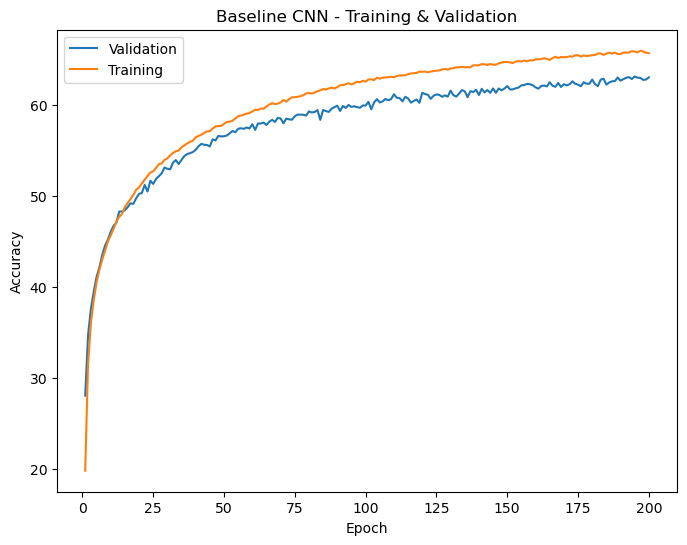

In [16]:
q3_1_val = q3_1.history['val_accuracy']
q3_1_val =[round(x * 100,2) for x in q3_1_val]
q3_1_trn = q3_1.history['accuracy']
q3_1_trn =[round(x * 100,2) for x in q3_1_trn]
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(q3_1_val)+1 ), q3_1_val, label='Validation')
plt.plot(range(1, len(q3_1_trn)+1 ), q3_1_trn, label='Training')
plt.title('Baseline CNN - Training & Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### LR 0.001

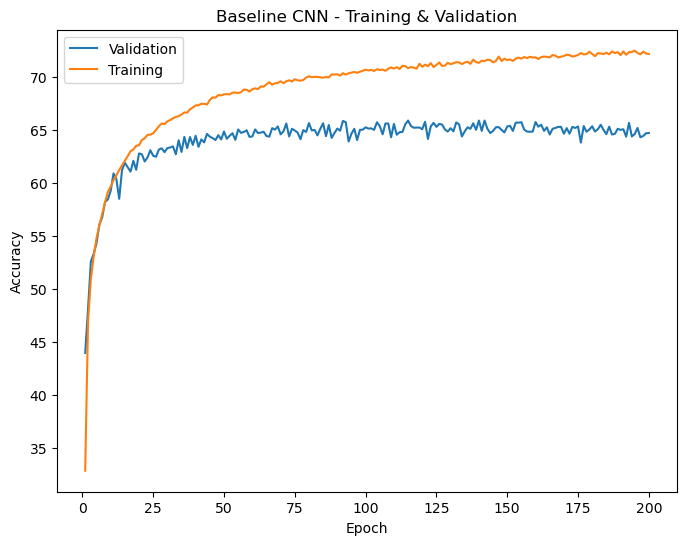

In [10]:
q3_1_valb = q3_1.history['val_accuracy']
q3_1_valb =[round(x * 100,2) for x in q3_1_valb]
q3_1_trnb = q3_1.history['accuracy']
q3_1_trnb =[round(x * 100,2) for x in q3_1_trnb]
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(q3_1_valb)+1 ), q3_1_valb, label='Validation')
plt.plot(range(1, len(q3_1_trnb)+1 ), q3_1_trnb, label='Training')
plt.title('Baseline CNN - Training & Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
model.save('q31.h5')

## Data Augmentation
- Augmented dataset #1: 
    - **brightened_images**: np.minimum(1.1 * X, 1.0)
- Augmented dataset #2:
    - **darkened_images** = 0.9 * X
- Augmented dataset #3: 
    - **Flip images horizontally**
- Augmented dataset #4: 
    - **Original Dataset**

- Concatenate all the above datasets to create new training set.

In [11]:
import numpy as np


# Augmented dataset #1: Brighten image by 10%
brightened_images = np.minimum(1.1 * train_norm, 1.0)

# Augmented dataset #2: Darken  image by 10%
darkened_images = 0.9 * train_norm

# Augmented dataset #3: Flip all images horizontally
flipped_images = np.flip(train_norm, axis=2)

# Augmented dataset #4: Original training set
original_images = train_norm

# Merge the augmented datasets into one gigantic training set
merged_images = np.concatenate([brightened_images, darkened_images, flipped_images, original_images], axis=0)
merged_labels = np.concatenate([train_labels, train_labels, train_labels, train_labels], axis=0)

# Scale back to 0-1 range
#merged_images = (merged_images + 1) / 2.0
#merged_images = merged_images * 2 - 1


# Verify the shape of the merged dataset
print("Merged Images Shape:", merged_images.shape)
print("Merged Labels Shape:", merged_labels.shape)


Merged Images Shape: (180000, 32, 32, 3)
Merged Labels Shape: (180000,)


**Rescale merged data to [-1,1]**

In [12]:
merged_scaled = rescale((merged_images))

## Augmentation verification

### Pixel min max comparison

- Verify the value of highest and lowest pixels (min,max)
    - **Bright Images** max and min values should be greater than that of original image.
    - **Dark Images** max and min values should be smaller than that of original image.
    - **Original Image** : Normalized image data.
    - **Flipped image**: max min value should be same to original image. 

Brightened Image -  (1.0, 0.008627450980392158)
Darkened Image   -  (0.8823529411764706, 0.007058823529411765)
Original Image   -  (0.9803921568627451, 0.00784313725490196)
Flipped Image    -  (0.9803921568627451, 0.00784313725490196)


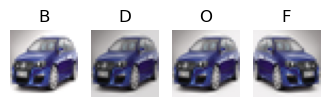

In [12]:
#n = 100
n = 6
b1 = brightened_images[n]
d1 = darkened_images[n]
o1 = original_images[n]
f1 = flipped_images[n]

# maximum and minimum pixel values for each image
brighten_max = np.max(b1)
brighten_min = np.min(b1)
darken_max = np.max(d1)
darken_min = np.min(d1)
original_max = np.max(o1)
original_min = np.min(o1)
flipped_max = np.max(f1)
flipped_min = np.min(f1)

# Print the results
print("Brightened Image - ",(brighten_max,brighten_min))
print("Darkened Image   - ",(darken_max,darken_min))
print("Original Image   - ",(original_max, original_min))
print("Flipped Image    - ",(original_max, original_min))

plt.figure(figsize=(4, 4))

# Brightened Image
plt.subplot(1, 4, 1)
plt.imshow(b1)
plt.title("B")
plt.axis('off')


# Darkened Image
plt.subplot(1, 4,2)
plt.imshow(d1)
plt.title("D")
plt.axis('off')


# Original Image
plt.subplot(1, 4,3)
plt.imshow(o1)
plt.title("O")
plt.axis('off')

plt.subplot(1, 4,4)
plt.imshow(f1)
plt.title("F")
plt.axis('off')

plt.show()

### Visual verification - Multiple labels

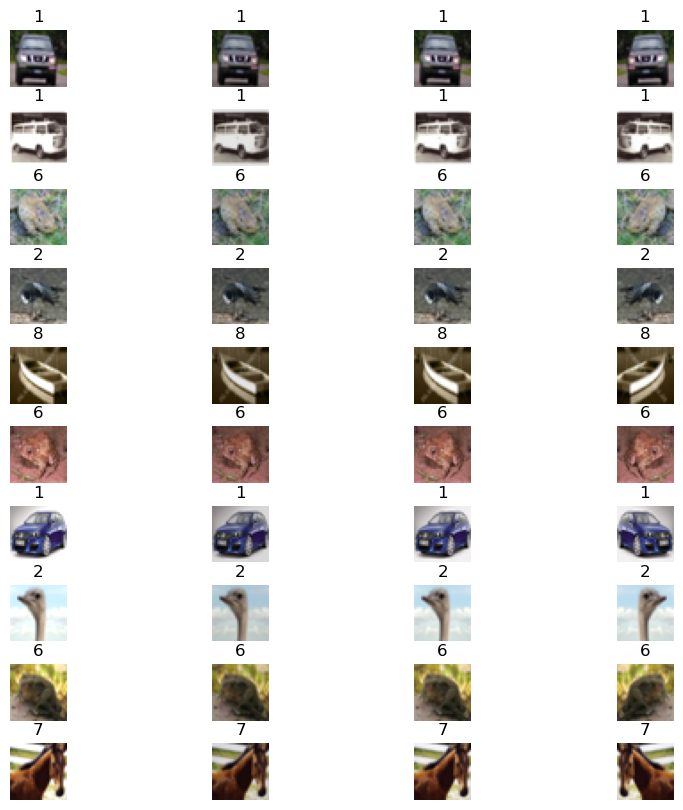

In [13]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# display the first 10 examples from each augmentation 
def aug_display(images, num_examples=10):
    plt.figure(figsize=(10, 10))
    
    for i in range(num_examples):
        for j, image in enumerate(images):
            image_array = (image[i] * 255).astype(np.uint8)
            image_pil = Image.fromarray(image_array)
            
            plt.subplot(num_examples, len(images), i * len(images) + j + 1)
            plt.imshow(image_pil) 
            plt.title(train_labels[i])
            plt.axis('off')
            plt.subplots_adjust(hspace=0.4) 

# first 10 examples from each augmentation type
aug_display([brightened_images, darkened_images, original_images,flipped_images])
plt.show()


## CNN Model - Augmented Data

In [13]:
model2 = (create_cnn_model)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model2 = model2()
model2.summary()
model2.compile(optimizer= optimizer, metrics=["accuracy"], loss = tf.keras.losses.sparse_categorical_crossentropy)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 10)        760       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 10)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 10, 10, 10)        2510      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 5, 5, 10)          0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 250)               0   

In [14]:
epochs = 200

q3_2= model2.fit(merged_scaled, merged_labels, epochs=epochs, validation_data=(val_scaled,val_labels), batch_size = 128)

Epoch 1/200
1407/1407 [==============================] - 51s 36ms/step - loss: 1.5444 - accuracy: 0.4379 - val_loss: 1.3253 - val_accuracy: 0.5228
Epoch 2/200
1407/1407 [==============================] - 48s 34ms/step - loss: 1.2378 - accuracy: 0.5594 - val_loss: 1.1979 - val_accuracy: 0.5764
Epoch 3/200
1407/1407 [==============================] - 46s 33ms/step - loss: 1.1438 - accuracy: 0.5956 - val_loss: 1.1672 - val_accuracy: 0.6006
Epoch 4/200
1407/1407 [==============================] - 47s 33ms/step - loss: 1.0882 - accuracy: 0.6167 - val_loss: 1.1054 - val_accuracy: 0.6124
Epoch 5/200
1407/1407 [==============================] - 46s 33ms/step - loss: 1.0490 - accuracy: 0.6312 - val_loss: 1.0603 - val_accuracy: 0.6266
Epoch 6/200
1407/1407 [==============================] - 47s 34ms/step - loss: 1.0149 - accuracy: 0.6449 - val_loss: 1.0548 - val_accuracy: 0.6314
Epoch 7/200
1407/1407 [==============================] - 48s 34ms/step - loss: 0.9913 - accuracy: 0.6540 - val_loss: 1

1407/1407 [==============================] - 47s 34ms/step - loss: 0.7829 - accuracy: 0.7268 - val_loss: 0.9686 - val_accuracy: 0.6760
Epoch 112/200
1407/1407 [==============================] - 47s 33ms/step - loss: 0.7815 - accuracy: 0.7264 - val_loss: 0.9843 - val_accuracy: 0.6686
Epoch 113/200
1407/1407 [==============================] - 47s 33ms/step - loss: 0.7822 - accuracy: 0.7253 - val_loss: 0.9779 - val_accuracy: 0.6686
Epoch 114/200
1407/1407 [==============================] - 48s 34ms/step - loss: 0.7819 - accuracy: 0.7266 - val_loss: 0.9818 - val_accuracy: 0.6698
Epoch 115/200
1407/1407 [==============================] - 46s 33ms/step - loss: 0.7852 - accuracy: 0.7251 - val_loss: 0.9821 - val_accuracy: 0.6670
Epoch 116/200
1407/1407 [==============================] - 47s 34ms/step - loss: 0.7821 - accuracy: 0.7260 - val_loss: 0.9748 - val_accuracy: 0.6726
Epoch 117/200
1407/1407 [==============================] - 48s 34ms/step - loss: 0.7800 - accuracy: 0.7271 - val_loss: 0

1407/1407 [==============================] - 47s 34ms/step - loss: 0.7689 - accuracy: 0.7303 - val_loss: 0.9627 - val_accuracy: 0.6748
Epoch 167/200
1407/1407 [==============================] - 48s 34ms/step - loss: 0.7697 - accuracy: 0.7303 - val_loss: 0.9603 - val_accuracy: 0.6750
Epoch 168/200
1407/1407 [==============================] - 48s 34ms/step - loss: 0.7696 - accuracy: 0.7300 - val_loss: 0.9636 - val_accuracy: 0.6768
Epoch 169/200
1407/1407 [==============================] - 48s 34ms/step - loss: 0.7709 - accuracy: 0.7297 - val_loss: 0.9820 - val_accuracy: 0.6694
Epoch 170/200
1407/1407 [==============================] - 48s 34ms/step - loss: 0.7665 - accuracy: 0.7306 - val_loss: 0.9855 - val_accuracy: 0.6676
Epoch 171/200
1407/1407 [==============================] - 48s 34ms/step - loss: 0.7679 - accuracy: 0.7304 - val_loss: 0.9675 - val_accuracy: 0.6776
Epoch 172/200
1407/1407 [==============================] - 48s 34ms/step - loss: 0.7684 - accuracy: 0.7303 - val_loss: 1

## Augmented Training vs Train accuracy

### LR 0.0001

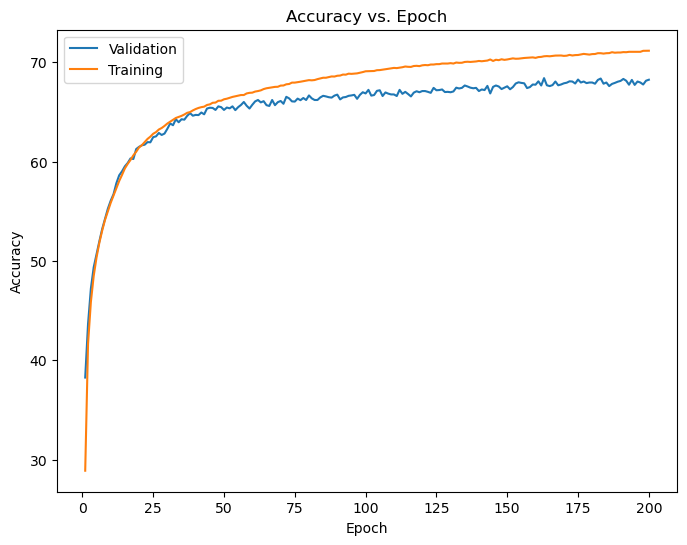

In [19]:
q3_2_val = q3_2.history['val_accuracy']
q3_2_val =[round(x * 100,2) for x in q3_2_val]
q3_2_trn = q3_2.history['accuracy']
q3_2_trn =[round(x * 100,2) for x in q3_2_trn]
# Create a plot of accuracy vs. epoch
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(q3_2_val)+1 ), q3_2_val, label='Validation')
plt.plot(range(1, len(q3_2_trn)+1 ), q3_2_trn, label='Training')
plt.title('Accuracy vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### LR 0.001

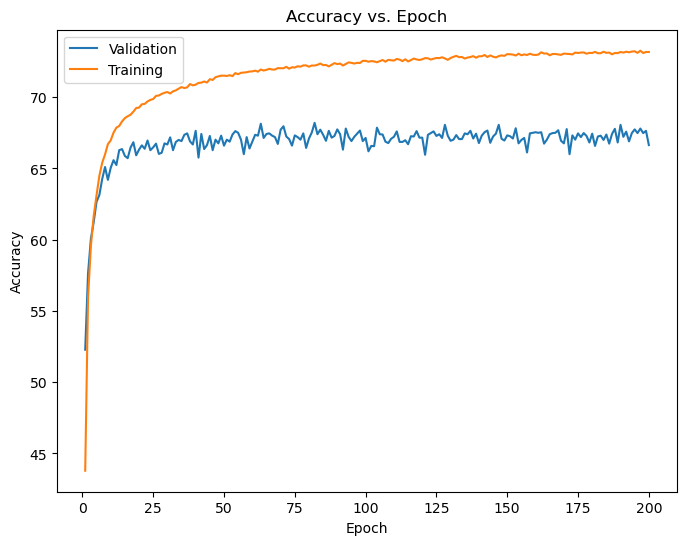

In [15]:
q3_2_val1 = q3_2.history['val_accuracy']
q3_2_val1 =[round(x * 100,2) for x in q3_2_val1]
q3_2_trn1 = q3_2.history['accuracy']
q3_2_trn1 =[round(x * 100,2) for x in q3_2_trn1]
# Create a plot of accuracy vs. epoch
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(q3_2_val1)+1 ), q3_2_val1, label='Validation')
plt.plot(range(1, len(q3_2_trn1)+1 ), q3_2_trn1, label='Training')
plt.title('Accuracy vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Baseline VS Augmented : Validation Acc 

### LR 0.0001

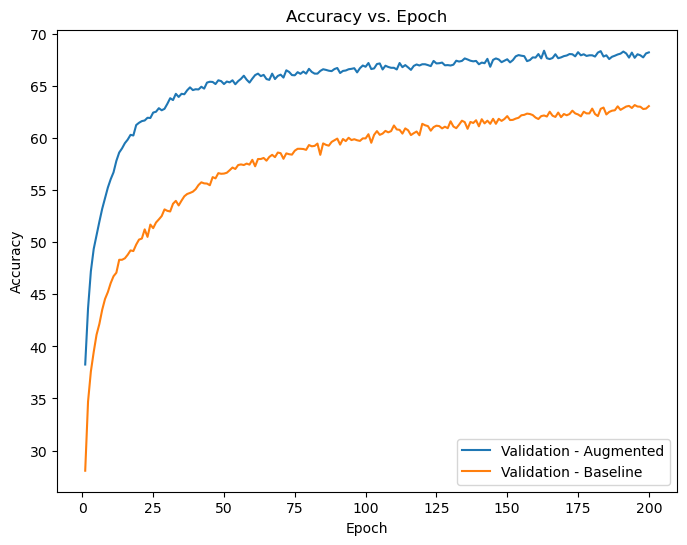

In [239]:

# Create a plot of accuracy vs. epoch
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(q3_2_val)+1 ), q3_2_val, label='Validation - Augmented')
plt.plot(range(1, len(q3_1_val)+1 ), q3_1_val, label='Validation - Baseline')
plt.title('Accuracy vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### LR 0.001

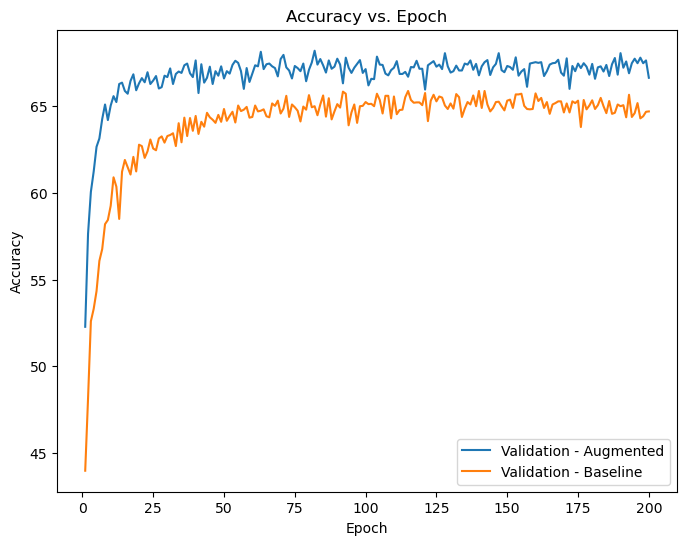

In [16]:

# Create a plot of accuracy vs. epoch
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(q3_2_val1)+1 ), q3_2_val1, label='Validation - Augmented')
plt.plot(range(1, len(q3_1_valb)+1 ), q3_1_valb, label='Validation - Baseline')
plt.title('Accuracy vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Self-Supervised Learning

In [249]:
# Path to the tar file
tar_file_path = '/Users/sahildhingra/Downloads/MSDS/SEM_6/Deep Learning/HW/HW2/cifar-10-python.tar'

# Extract the tar file
with tarfile.open(tar_file_path, 'r') as tar:
    tar.extractall()

# Load CIFAR-10 data from extracted files
def load_cifar10_batch(file_path):
    with open(file_path, 'rb') as fo:
        data = pickle.load(fo, encoding='bytes')
    return data

# Load all training batches and concatenate them
all_train_images = []
all_train_labels = []
for i in range(1, 6):  
    batch_data = load_cifar10_batch(f'cifar-10-batches-py/data_batch_{i}')
    batch_images = np.array(batch_data[b'data']).reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
    batch_labels = np.array(batch_data[b'labels'])
    all_train_images.append(batch_images)
    all_train_labels.append(batch_labels)

# Concatenate all training batches
train_images = np.concatenate(all_train_images, axis=0)
train_labels = np.concatenate(all_train_labels, axis=0)

#  test data
test_data = load_cifar10_batch('cifar-10-batches-py/test_batch')
test_images = np.array(test_data[b'data']).reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
test_labels = np.array(test_data[b'labels'])

# Split data into train, validation, and test sets
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels,shuffle = True, test_size=0.01, random_state=42,stratify = train_labels)

print("Train Images Shape:", train_images.shape)
print("Train Labels Shape:", train_labels.shape)
print("Validation Images Shape:", val_images.shape)
print("Validation Labels Shape:", val_labels.shape)
print("Test Images Shape:", test_images.shape)
print("Test Labels Shape:", test_labels.shape)

Train Images Shape: (49500, 32, 32, 3)
Train Labels Shape: (49500,)
Validation Images Shape: (500, 32, 32, 3)
Validation Labels Shape: (500,)
Test Images Shape: (10000, 32, 32, 3)
Test Labels Shape: (10000,)


In [250]:
train_scaled = rescale(normalize(train_images))
val_scaled = rescale(normalize(val_images))
val_norm = normalize(val_images)
train_norm = normalize(train_images)
test_scaled = rescale(normalize(test_images))


In [22]:

org = train_norm
flp = np.flipud(train_norm)
r90 = np.rot90(train_norm, k=1, axes=(1, 2))


# Create labels with value 0 for all records
r90_labels = np.full(r90.shape[0], 2)
flp_labels = np.full(flp.shape[0], 1)
org_labels = np.full(org.shape[0], 0)


# Augmented dataset #1: Brighten every pixel in every image by 10%
r90 = np.rot90(train_norm, k=1, axes=(1, 2))

# Augmented dataset #2: Darken every pixel in every image by 10%
flp =  np.array([np.flipud(image) for image in train_norm])

# org dataset #3: Flip all images horizontally
org = train_norm

# Augmented dataset #4: Original training set


# Merge the augmented datasets into one gigantic training set
merged_images = np.concatenate([r90, flp, org], axis=0)
merged_labels = np.concatenate([r90_labels, flp_labels, org_labels], axis=0)

# Scale back to 0-1 range
#merged_images = (merged_images + 1) / 2.0
#merged_images = merged_images * 2 - 1


# Verify the shape of the merged dataset
print("Merged Images Shape:", merged_images.shape)
print("Merged Labels Shape:", merged_labels.shape)

Merged Images Shape: (148500, 32, 32, 3)
Merged Labels Shape: (148500,)


In [23]:
merged_rescaled = rescale((merged_images))

## Augmentation Verification

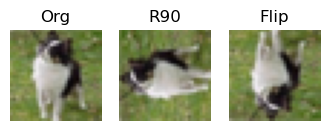

In [24]:
# Choose one image from each dataset
#100
n = 6
r1 = r90[n]
f1 = flp[n]
o1 = train_norm[n]

# Create subplots for side by side comparison
plt.figure(figsize=(4, 4))

# Brightened Image
plt.subplot(1, 3, 2)
plt.imshow(r1)
plt.title("R90")
plt.axis('off')


# Darkened Image
plt.subplot(1, 3, 3)
plt.imshow(f1)
plt.title("Flip")
plt.axis('off')


# Original Image
plt.subplot(1, 3, 1)
plt.imshow(o1)
plt.title("Org")
plt.axis('off')


plt.show()

### Visual verification - Multiple labels

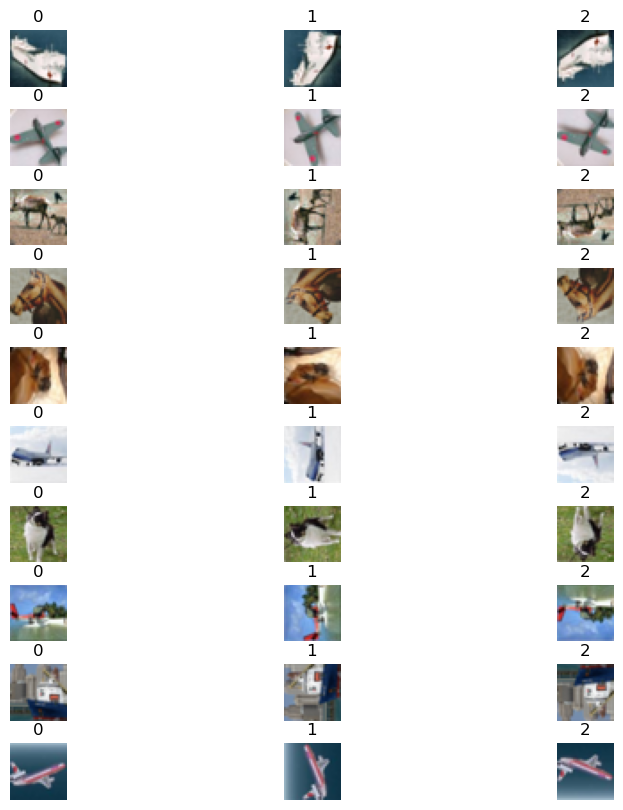

In [242]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# display the first 10 examples from each augmentation 
def aug_display(images, num_examples=10):
    plt.figure(figsize=(10, 10))
    
    for i in range(num_examples):
        for j, image in enumerate(images):
            image_array = (image[i] * 255).astype(np.uint8)
            image_pil = Image.fromarray(image_array)
            
            plt.subplot(num_examples, len(images), i * len(images) + j + 1)
            plt.imshow(image_pil) 
            plt.title(str(j))
            plt.axis('off')
            plt.subplots_adjust(hspace=0.4) 

# first 10 examples from each augmentation type
aug_display([org, r90, flp])
plt.show()

## Baseline Model - 3 classes

In [25]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.initializers import he_normal

def create_cnn_model3(input_shape=(32, 32, 3), num_classes=3):
    # Input layer
    input_layer = Input(shape=input_shape)
    
    conv1 = Conv2D(10, (5, 5), strides=(1, 1), kernel_initializer=he_normal(), activation='relu')(input_layer)
    
    maxpool1 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(conv1)
    
    conv2 = Conv2D(10, (5, 5), strides=(1, 1), activation='relu',kernel_initializer=he_normal())(maxpool1)
    
    maxpool2 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(conv2)
    
    flatten = Flatten()(maxpool2)
    
    fc1 = Dense(20, activation='relu',kernel_initializer=he_normal())(flatten)
    
    output_layer = Dense(num_classes, activation='softmax')(fc1)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    
    return model


model3 = create_cnn_model3()
model3.summary()


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 28, 28, 10)        760       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 14, 14, 10)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 10, 10, 10)        2510      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 5, 5, 10)          0         
 g2D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 250)               0   

In [26]:
#step 3f
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001)
model3.compile(optimizer=optimizer, loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])

q4_1 = model3.fit(merged_rescaled, merged_labels, epochs=100, shuffle=True, batch_size = 32)

Epoch 1/100
4641/4641 [==============================] - 60s 13ms/step - loss: 0.8182 - accuracy: 0.6179
Epoch 2/100
4641/4641 [==============================] - 52s 11ms/step - loss: 0.7212 - accuracy: 0.6788
Epoch 3/100
4641/4641 [==============================] - 51s 11ms/step - loss: 0.6867 - accuracy: 0.6968
Epoch 4/100
4641/4641 [==============================] - 51s 11ms/step - loss: 0.6667 - accuracy: 0.7073
Epoch 5/100
4641/4641 [==============================] - 51s 11ms/step - loss: 0.6519 - accuracy: 0.7141
Epoch 6/100
4641/4641 [==============================] - 51s 11ms/step - loss: 0.6401 - accuracy: 0.7211
Epoch 7/100
4641/4641 [==============================] - 51s 11ms/step - loss: 0.6318 - accuracy: 0.7262
Epoch 8/100
4641/4641 [==============================] - 51s 11ms/step - loss: 0.6231 - accuracy: 0.7317
Epoch 9/100
4641/4641 [==============================] - 51s 11ms/step - loss: 0.6155 - accuracy: 0.7347
Epoch 10/100
4641/4641 [==============================]

In [28]:
from tensorflow.keras.models import load_model
model3.save('/Users/sahildhingra/Downloads/MSDS/SEM_6/Deep Learning/HW/HW2/models/q4_3_class_model_10120241.h5')

/Users/sahildhingra/opt/anaconda3/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [68]:
pretrained_q4_3_class_model = load_model('/Users/sahildhingra/Downloads/MSDS/SEM_6/Deep Learning/HW/HW2/models/q4_3_class_model_10120241.h5')

## Pretext Models

### Pretext Model - No Validation Data

In [244]:
model51 = create_cnn_model()
model51.summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_26 (Conv2D)          (None, 28, 28, 10)        760       
                                                                 
 max_pooling2d_26 (MaxPooli  (None, 14, 14, 10)        0         
 ng2D)                                                           
                                                                 
 conv2d_27 (Conv2D)          (None, 10, 10, 10)        2510      
                                                                 
 max_pooling2d_27 (MaxPooli  (None, 5, 5, 10)          0         
 ng2D)                                                           
                                                                 
 flatten_18 (Flatten)        (None, 250)               0  

In [31]:
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001)
model51.compile(optimizer=optimizer, loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])

model51 = model51.fit(val_scaled, val_labels, epochs=200, shuffle=True)

Epoch 1/200
16/16 [==============================] - 1s 14ms/step - loss: 2.2904 - accuracy: 0.1100
Epoch 2/200
16/16 [==============================] - 0s 13ms/step - loss: 2.1955 - accuracy: 0.1720
Epoch 3/200
16/16 [==============================] - 0s 14ms/step - loss: 2.1117 - accuracy: 0.2140
Epoch 4/200
16/16 [==============================] - 0s 13ms/step - loss: 2.0280 - accuracy: 0.2560
Epoch 5/200
16/16 [==============================] - 0s 13ms/step - loss: 1.9383 - accuracy: 0.2900
Epoch 6/200
16/16 [==============================] - 0s 13ms/step - loss: 1.8541 - accuracy: 0.3460
Epoch 7/200
16/16 [==============================] - 0s 14ms/step - loss: 1.7617 - accuracy: 0.3600
Epoch 8/200
16/16 [==============================] - 0s 14ms/step - loss: 1.6653 - accuracy: 0.3960
Epoch 9/200
16/16 [==============================] - 0s 14ms/step - loss: 1.6009 - accuracy: 0.4100
Epoch 10/200
16/16 [==============================] - 0s 13ms/step - loss: 1.5062 - accuracy: 0.4820

### Model with 10,000 validation Data

#### 200 Epochs

In [33]:
model51_with_testdata = create_cnn_model()
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001)
model51_with_testdata.compile(optimizer=optimizer, loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])

q4_3 = model51_with_testdata.fit(val_scaled, val_labels, epochs=200,validation_data=(test_scaled,test_labels), shuffle=True)

Epoch 1/200
16/16 [==============================] - 2s 124ms/step - loss: 2.3625 - accuracy: 0.1020 - val_loss: 2.3394 - val_accuracy: 0.1081
Epoch 2/200
16/16 [==============================] - 1s 87ms/step - loss: 2.3350 - accuracy: 0.1060 - val_loss: 2.3252 - val_accuracy: 0.1066
Epoch 3/200
16/16 [==============================] - 1s 87ms/step - loss: 2.3189 - accuracy: 0.1080 - val_loss: 2.3168 - val_accuracy: 0.1058
Epoch 4/200
16/16 [==============================] - 1s 84ms/step - loss: 2.3087 - accuracy: 0.1120 - val_loss: 2.3109 - val_accuracy: 0.1063
Epoch 5/200
16/16 [==============================] - 1s 89ms/step - loss: 2.3005 - accuracy: 0.1240 - val_loss: 2.3053 - val_accuracy: 0.1094
Epoch 6/200
16/16 [==============================] - 1s 93ms/step - loss: 2.2928 - accuracy: 0.1240 - val_loss: 2.3013 - val_accuracy: 0.1132
Epoch 7/200
16/16 [==============================] - 1s 88ms/step - loss: 2.2863 - accuracy: 0.1240 - val_loss: 2.2974 - val_accuracy: 0.1143
Epoch

#### 10000 Epochs

In [176]:
model51_with_testdata = create_cnn_model()
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001)
model51_with_testdata.compile(optimizer=optimizer, loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])

q4_3 = model51_with_testdata.fit(val_scaled, val_labels, epochs=10000,validation_data=(test_scaled,test_labels), shuffle=True)

Epoch 1/10000
16/16 [==============================] - 2s 111ms/step - loss: 2.3724 - accuracy: 0.0880 - val_loss: 2.3494 - val_accuracy: 0.0851
Epoch 2/10000
16/16 [==============================] - 1s 76ms/step - loss: 2.3378 - accuracy: 0.0920 - val_loss: 2.3313 - val_accuracy: 0.0859
Epoch 3/10000
16/16 [==============================] - 1s 80ms/step - loss: 2.3191 - accuracy: 0.0920 - val_loss: 2.3200 - val_accuracy: 0.0886
Epoch 4/10000
16/16 [==============================] - 1s 77ms/step - loss: 2.3055 - accuracy: 0.0920 - val_loss: 2.3130 - val_accuracy: 0.0906
Epoch 5/10000
16/16 [==============================] - 1s 77ms/step - loss: 2.2951 - accuracy: 0.1040 - val_loss: 2.3076 - val_accuracy: 0.0947
Epoch 6/10000
16/16 [==============================] - 1s 74ms/step - loss: 2.2856 - accuracy: 0.1100 - val_loss: 2.3035 - val_accuracy: 0.0979
Epoch 7/10000
16/16 [==============================] - 1s 71ms/step - loss: 2.2784 - accuracy: 0.1140 - val_loss: 2.2999 - val_accuracy

## Model for Transfer learning

In [86]:

model50_with_pretrain = create_cnn_model()
model50_with_pretrain.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_20 (Conv2D)          (None, 28, 28, 10)        760       
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 14, 14, 10)        0         
 ng2D)                                                           
                                                                 
 conv2d_21 (Conv2D)          (None, 10, 10, 10)        2510      
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 5, 5, 10)          0         
 ng2D)                                                           
                                                                 
 flatten_10 (Flatten)        (None, 250)               0  

### Weight transfer till 2nd last layer

In [140]:
shared_layers = pretrained_q4_3_class_model.layers[:-1] 
for i in range(len(shared_layers)):
    model50_with_pretrain.layers[i].set_weights(pretrained_q4_3_class_model.layers[i].get_weights())

### Last layer initialization: He Normal

In [142]:
#https://towardsdatascience.com/weight-initialization-techniques-in-neural-networks-26c649eb3b78

num_units = model50_with_pretrain.layers[-1].units
previous_layer_units = model50_with_pretrain.layers[-2].units

initializer = HeNormal(seed = 42)
weights = initializer(shape=(previous_layer_units, num_units))
biases = np.zeros(num_units)
model50_with_pretrain.layers[-1].set_weights([weights,biases])

### Multiple optimizers

In [143]:
#https://www.tensorflow.org/addons/api_docs/python/tfa/optimizers/MultiOptimizer

optimizers = [
    tf.keras.optimizers.legacy.Adam(learning_rate=1e-6),
    tf.keras.optimizers.legacy.Adam(learning_rate=1e-3)
]
optimizers_and_layers = [(optimizers[0], model50_with_pretrain.layers[:-1]), (optimizers[1], model50_with_pretrain.layers[-1])]
optimizer = tfa.optimizers.MultiOptimizer(optimizers_and_layers)

In [144]:

model50_with_pretrain.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [145]:

model50_with_pretrain1 = model50_with_pretrain.fit(val_scaled, val_labels, epochs=10000,validation_data=(test_scaled,test_labels), shuffle=True)

Epoch 1/10000
16/16 [==============================] - 4s 150ms/step - loss: 2.3256 - accuracy: 0.1160 - val_loss: 2.2918 - val_accuracy: 0.1403
Epoch 2/10000
16/16 [==============================] - 2s 136ms/step - loss: 2.2753 - accuracy: 0.1520 - val_loss: 2.2543 - val_accuracy: 0.1534
Epoch 3/10000
16/16 [==============================] - 2s 117ms/step - loss: 2.2335 - accuracy: 0.1720 - val_loss: 2.2230 - val_accuracy: 0.1633
Epoch 4/10000
16/16 [==============================] - 2s 118ms/step - loss: 2.1983 - accuracy: 0.1720 - val_loss: 2.1977 - val_accuracy: 0.1742
Epoch 5/10000
16/16 [==============================] - 2s 120ms/step - loss: 2.1671 - accuracy: 0.2080 - val_loss: 2.1759 - val_accuracy: 0.1816
Epoch 6/10000
16/16 [==============================] - 3s 192ms/step - loss: 2.1399 - accuracy: 0.2200 - val_loss: 2.1559 - val_accuracy: 0.1938
Epoch 7/10000
16/16 [==============================] - 2s 116ms/step - loss: 2.1150 - accuracy: 0.2440 - val_loss: 2.1368 - val_ac

In [159]:
qval_43_pretrain= []
qval_43_pretrain=[]
qval_43_pretrain = model50_with_pretrain1.history["val_accuracy"][::100]
qval_43_pretrain =[round(x * 100,2) for x in qval_43_pretrain]

In [ ]:
qval_b_43 = q4_3.history["val_accuracy"]
qval_b_43 =[round(x * 100,2) for x in qval_b_43]

In [180]:
qval_b_43_cpy = qval_b_43.copy()

## Transfer Learning Validation Accuracy  Visualizations

### No TF - 200 epochs, TF - 10 k epochs

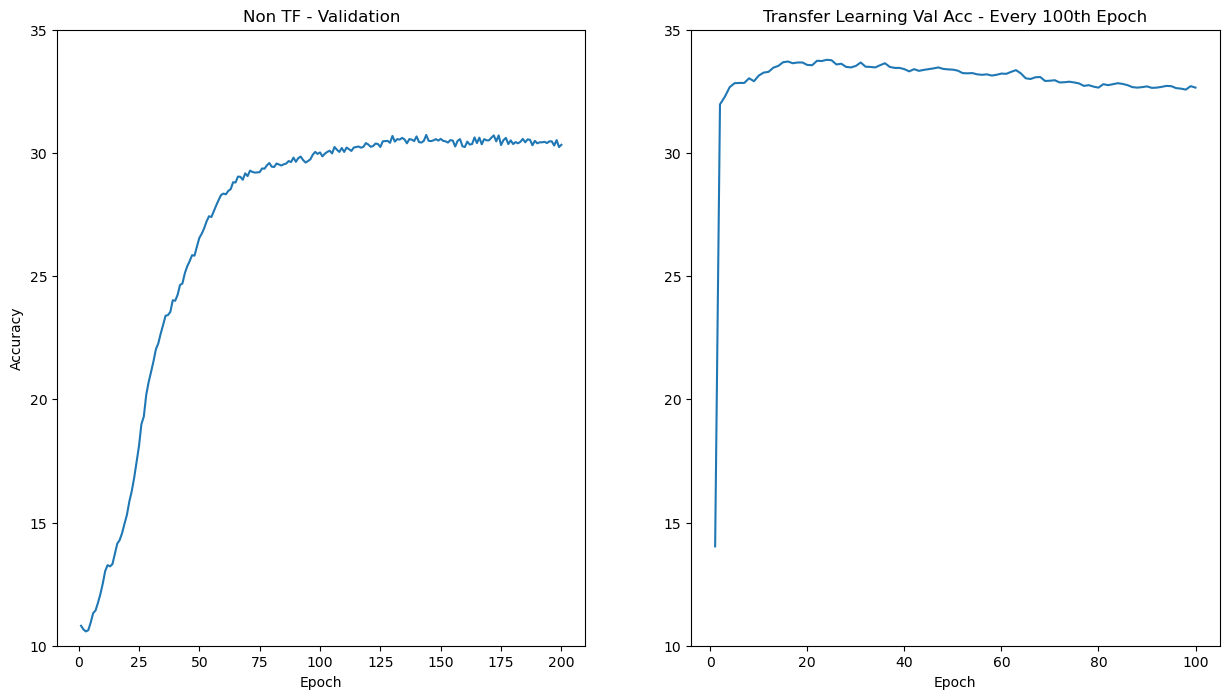

In [174]:

plt.figure(figsize=(15,8))
plt.subplot(1, 2, 1)

#plt.figure(figsize=(8, 6))
plt.plot(range(1, len(qval_b_43)+1 ), qval_b_43, label='Validation')
plt.title('No Transfer LEarning')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
#plt.legend()
plt.ylim(10,35)
#plt.show()

plt.subplot(1, 2, 2)
plt.plot(range(1, len(qval_43_pretrain)+1 ), qval_43_pretrain, label='Validation')
plt.title('Transfer Learning Val Acc - Every 100th Epoch')
plt.xlabel('Epoch')
plt.ylim(10,35)
#plt.ylabel('Accuracy')
#plt.legend()
plt.show()



In [178]:
qval_b_43_10k = []
qval_b_43_10k = q4_3.history["val_accuracy"]
qval_b_43_10k =[round(x * 100,2) for x in qval_b_43_10k[::100]]

### No TF and TF - 10 k epochs each

Baseline: We saw that pretext/basleine model was giving accuracy around ~30% when we used remaining 
test set of 10 k. When we used transfer learing and used weights of the model with 3 classes it improved the accuracy on the same data to around ~34%. Considering that we are getting weights from a model with 3 classes and 100 odd epochs and using it on a model with 10 classes, it shows improvement compared to model where we did not use transfer learning. It shows that if we have prior good models, we can use the weights to get better results.

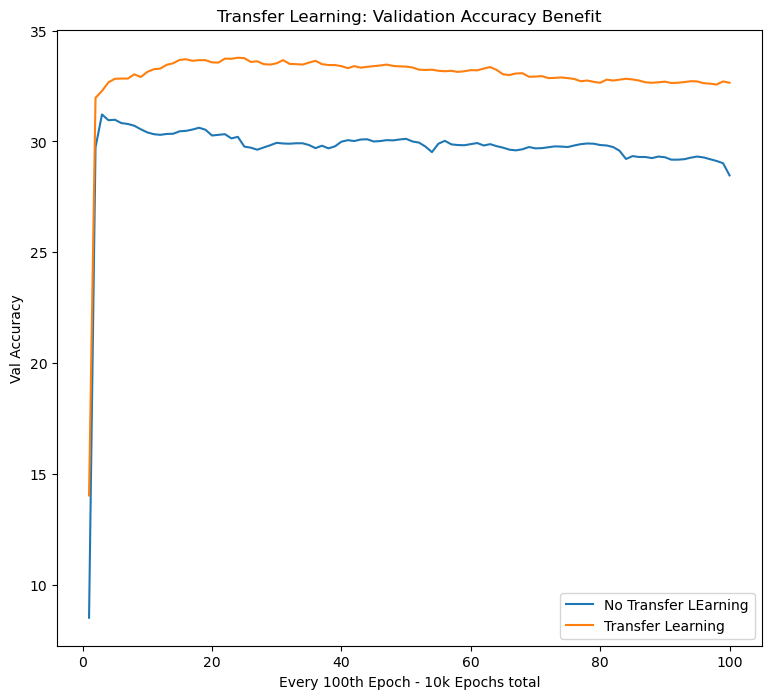

In [271]:
plt.figure(figsize=(20,8))
plt.subplot(1, 2, 1)

#plt.figure(figsize=(8, 6))
plt.plot(range(1, len(qval_b_43_10k)+1 ), qval_b_43_10k, label='No Transfer LEarning')
plt.plot(range(1, len(qval_43_pretrain)+1 ), qval_43_pretrain, label='Transfer Learning')
plt.title('Transfer Learning: Validation Accuracy Benefit')
plt.xlabel('Every 100th Epoch - 10k Epochs total')
plt.ylabel('Val Accuracy')
plt.legend()
plt.ylim(10,35)
plt.show()